# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.675'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [1]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


NameError: name 'utils' is not defined

In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='linear', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(CuDNNLSTM(200))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 111, 64)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 3s 5ms/step - loss: 0.8475 - val_loss: 0.1987
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.4500 - val_loss: 0.1531
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.3251 - val_loss: 0.1033
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.2354 - val_loss: 0.0641
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.2053 - val_loss: 0.0719
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1713 - val_loss: 0.0356
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1549 - val_loss: 0.0408
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1373 - val_loss: 0.0303
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0034
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0033
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0042
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0027
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 85/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 86/1000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 159/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 160/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 161/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 162/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 163/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0124
Epoch 164/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 165/1000
585/585 [==============================] - 1s 1ms

Epoch 235/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 236/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 237/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 238/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 239/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 240/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 241/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 242/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 243/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 244/1000
585/585 [==============================] - 1s 1ms

Epoch 314/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 315/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 9.7515e-04
Epoch 316/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 317/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 318/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 319/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 320/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 321/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 322/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 323/1000
585/585 [==============================] - 1s

585/585 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 9.7327e-04
Epoch 471/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 472/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 473/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 8.3108e-04
Epoch 474/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 8.2480e-04
Epoch 475/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 7.9839e-04
Epoch 476/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 477/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 478/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 479/1000
585/585 [==============================] - 1s 1m

585/585 [==============================] - 1s 1ms/step - loss: 8.5057e-04 - val_loss: 6.7775e-04
Epoch 625/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.5381e-04 - val_loss: 6.5284e-04
Epoch 626/1000
585/585 [==============================] - 1s 1ms/step - loss: 9.3110e-04 - val_loss: 0.0011
Epoch 627/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 628/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 6.9559e-04
Epoch 629/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.9154e-04 - val_loss: 5.3271e-04
Epoch 630/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.1104e-04 - val_loss: 7.9268e-04
Epoch 631/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.0131e-04 - val_loss: 5.6649e-04
Epoch 632/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 8.5636e-04
Epoch 633/1000
585/585 [===

585/585 [==============================] - 1s 1ms/step - loss: 7.2894e-04 - val_loss: 5.1508e-04
Epoch 773/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.9242e-04 - val_loss: 6.0617e-04
Epoch 774/1000
585/585 [==============================] - 1s 1ms/step - loss: 8.1575e-04 - val_loss: 5.1843e-04
Epoch 775/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.4251e-04 - val_loss: 5.2346e-04
Epoch 776/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.9577e-04 - val_loss: 6.9787e-04
Epoch 777/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.8351e-04 - val_loss: 6.1209e-04
Epoch 778/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.2910e-04 - val_loss: 5.1877e-04
Epoch 779/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.4253e-04 - val_loss: 4.8751e-04
Epoch 780/1000
585/585 [==============================] - 1s 1ms/step - loss: 6.8190e-04 - val_loss: 4.7101e-04
Epoch 7

585/585 [==============================] - 1s 1ms/step - loss: 5.2690e-04 - val_loss: 4.1475e-04
Epoch 919/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.5999e-04 - val_loss: 4.5441e-04
Epoch 920/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.3383e-04 - val_loss: 3.8908e-04
Epoch 921/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.4385e-04 - val_loss: 3.7209e-04
Epoch 922/1000
585/585 [==============================] - 1s 1ms/step - loss: 4.9355e-04 - val_loss: 3.9543e-04
Epoch 923/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.4178e-04 - val_loss: 5.8864e-04
Epoch 924/1000
585/585 [==============================] - 1s 1ms/step - loss: 5.6819e-04 - val_loss: 7.8764e-04
Epoch 925/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 9.3943e-04
Epoch 926/1000
585/585 [==============================] - 1s 1ms/step - loss: 9.1010e-04 - val_loss: 6.4594e-04
Epoch 927/1

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0003012326161553245
MSE Dev: 0.0004330436971127819
MSE Test: 0.00045923717548846874
MAE Train: 0.012995170600403347
MAE Dev: 0.014664933781972108
MAE Test: 0.018556161396070556


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

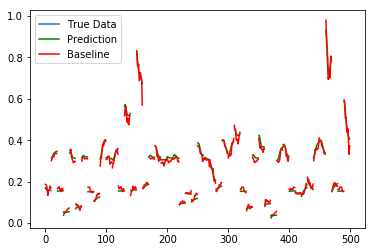

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

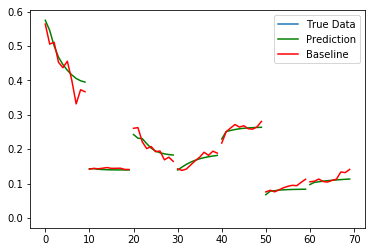

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.0002516893722618972
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.0002516893722618972


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

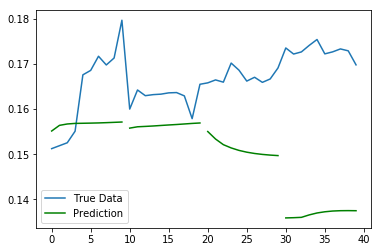

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

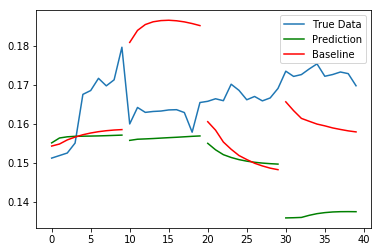

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.017087646334872936
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.000436044428099365


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



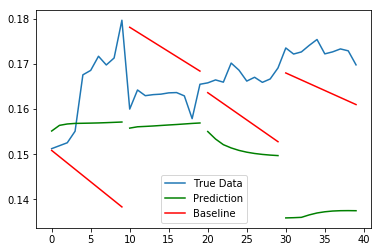

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.017087646334872936
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.000436044428099365


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

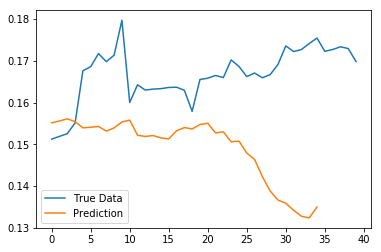

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

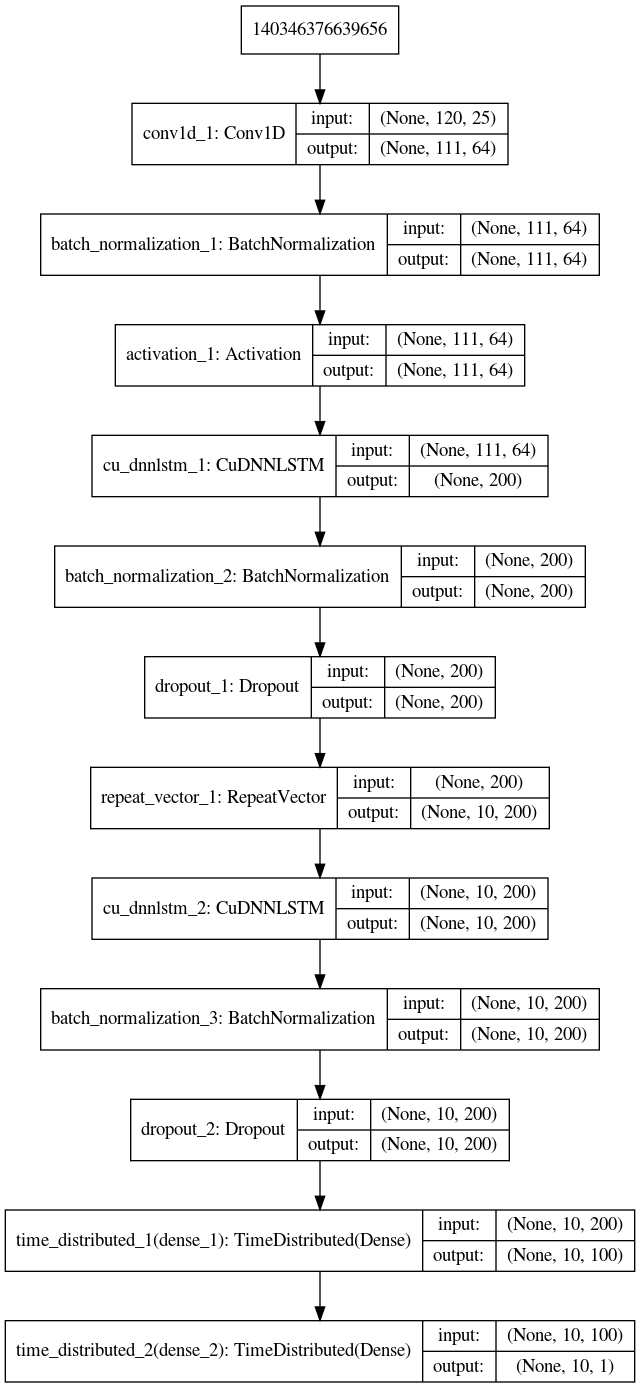

In [14]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))